In [1]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt

# Import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


# Import util functions
import utils

In [2]:
# Collect json and image location
train_json_loc, train_image_loc = utils.get_json_and_images("train")

# if your dataset is in COCO format, this cell can be replaced by the following three lines:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_dataset", {}, train_json_loc, train_image_loc)

In [3]:
# add keypoint_names metadata needed for training

rhexis_keypoint_names = ["utrada_tip1", "utrada_tip2"]
rhexis_flip_map = [("utrada_tip1", "utrada_tip2")]

MetadataCatalog.get("train_dataset").keypoint_names = rhexis_keypoint_names
#MetadataCatalog.get("my_dataset_val").keypoint_names = rhexis_keypoint_names
#MetadataCatalog.get("my_dataset_test").keypoint_names = rhexis_keypoint_names

MetadataCatalog.get("train_dataset").keypoint_flip_map = rhexis_flip_map
#MetadataCatalog.get("my_dataset_val").keypoint_flip_map = rhexis_flip_map
#MetadataCatalog.get("my_dataset_test").keypoint_flip_map = rhexis_flip_map

[04/29 23:01:02 d2.data.datasets.coco]: Loaded 320 images in COCO format from /Users/bviggiano/Google Drive/My Drive/Stanford/Spring2022/RhexisProject/Rhexis_Project_Main/datasets/train_set/train_coco_keypoints_annotations.json


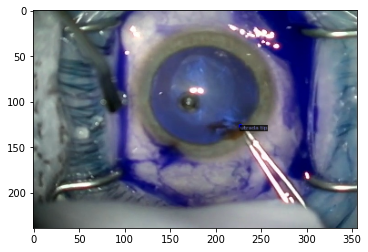

In [4]:
# visualize training data
dataset_dicts = DatasetCatalog.get("train_dataset") 
train_metadata = MetadataCatalog.get("train_dataset")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])

In [6]:
# Fine-tune COCO-pretrained R50-FPN Keypoint RCNN on dataset

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_dataset",)
cfg.DATASETS.TEST = () # "my_dataset_val",
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.000025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 was good for balloon toy dataset. Adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for balloon toy dataset (default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (utrada tip). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.  
cfg.MODEL.KEYPOINT_ON = True
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 2
cfg.TEST.KEYPOINT_OKS_SIGMAS = [1.0, 1.0] 

# cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False # keep and do not exclude images labeled to have no objects

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/29 23:05:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a6e10b.pkl: 237MB [00:08, 27.0MB/s]                              
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 2, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


[04/29 23:05:40 d2.engine.train_loop]: Starting training from iteration 0


/Users/bviggiano/miniconda3/envs/rhexis_project/lib/python3.10/site-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1651023700168/work/torch/csrc/utils/tensor_new.cpp:210.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/Users/bviggiano/miniconda3/envs/rhexis_project/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1651023700168/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/bviggiano/miniconda3/envs/rhexis_project/lib/python3.10/sit

[04/29 23:07:17 d2.engine.hooks]: Overall training speed: 4 iterations in 0:01:06 (16.6378 s / it)
[04/29 23:07:17 d2.engine.hooks]: Total training time: 0:01:06 (0:00:00 on hooks)
[04/29 23:07:17 d2.utils.events]:  eta: 3:29:21  iter: 6  total_loss: 0.1815  loss_cls: 0.06445  loss_box_reg: 0.004895  loss_keypoint: 0  loss_rpn_cls: 0.1022  loss_rpn_loc: 0.005511  time: 13.1552  data_time: 0.2448  lr: 1.4988e-07  


KeyboardInterrupt: 

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/12 20:16:33 d2.data.datasets.coco]: Loaded 320 images in COCO format from /content/drive/MyDrive/Rhexis/train_coco_keypoints_annotations2_modified_bbox.json


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


{'instances': Instances(num_instances=1, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 154.7420,   10.6454, 1920.0000, 1080.0000]], device='cuda:0')), scores: tensor([0.9296], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[1.5104e+03, 3.3663e+02, 1.1979e-03],
         [1.1965e+03, 4.8775e+02, 1.3512e-03]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[ 0.2088,  0.4152,  0.8280,  ...,  0.2575,  0.3866,  0.4511],
          [ 0.1042,  0.2978,  0.6849,  ...,  0.0824,  0.1939,  0.2497],
          [-0.1050,  0.0629,  0.3987,  ..., -0.2676, -0.1914, -0.1533],
          ...,
          [-0.2757, -0.1161,  0.2030,  ..., -0.1453,  0.0185,  0.1004],
          [-0.1798, -0.0739,  0.1379,  ..., -0.1984, -0.0327,  0.0502],
          [-0.1319, -0.0528,  0.1053,  ..., -0.2250, -0.0583,  0.0251]],

         [[ 0.4184,  0.4425,  0.4906,  ...,  0.4388,  0.3578,  0.3173],
          [ 0.3604,  0.3120,  0.2152,  ...,  0.2661,  0.3071

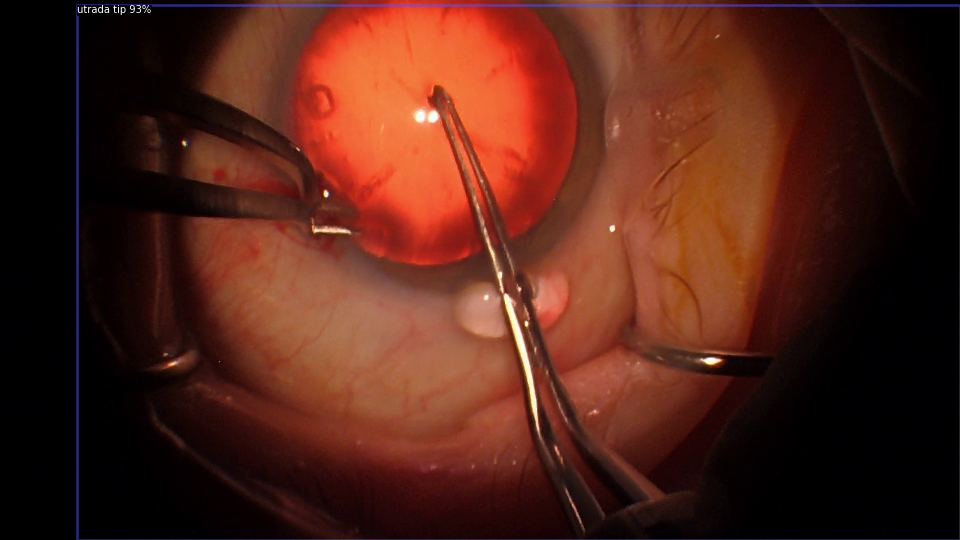

{'instances': Instances(num_instances=1, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 159.9704,    6.0978, 1752.6365, 1073.0746]], device='cuda:0')), scores: tensor([0.9328], device='cuda:0'), pred_classes: tensor([0], device='cuda:0'), pred_keypoints: tensor([[[1.0405e+03, 3.2936e+02, 2.0934e-03],
         [6.4022e+02, 1.7817e+02, 2.2791e-03]]], device='cuda:0'), pred_keypoint_heatmaps: tensor([[[[ 0.2235,  0.3902,  0.7238,  ...,  0.0114,  0.3759,  0.5581],
          [ 0.1523,  0.2946,  0.5793,  ..., -0.1006,  0.2148,  0.3726],
          [ 0.0099,  0.1034,  0.2904,  ..., -0.3247, -0.1073,  0.0014],
          ...,
          [-0.2842, -0.1417,  0.1434,  ..., -0.1234,  0.0417,  0.1242],
          [-0.1448, -0.0598,  0.1102,  ..., -0.1940, -0.0167,  0.0719],
          [-0.0750, -0.0188,  0.0936,  ..., -0.2293, -0.0459,  0.0458]],

         [[ 0.5675,  0.5415,  0.4895,  ...,  0.6290,  0.4000,  0.2855],
          [ 0.4055,  0.3429,  0.2177,  ...,  0.3799,  0.3325

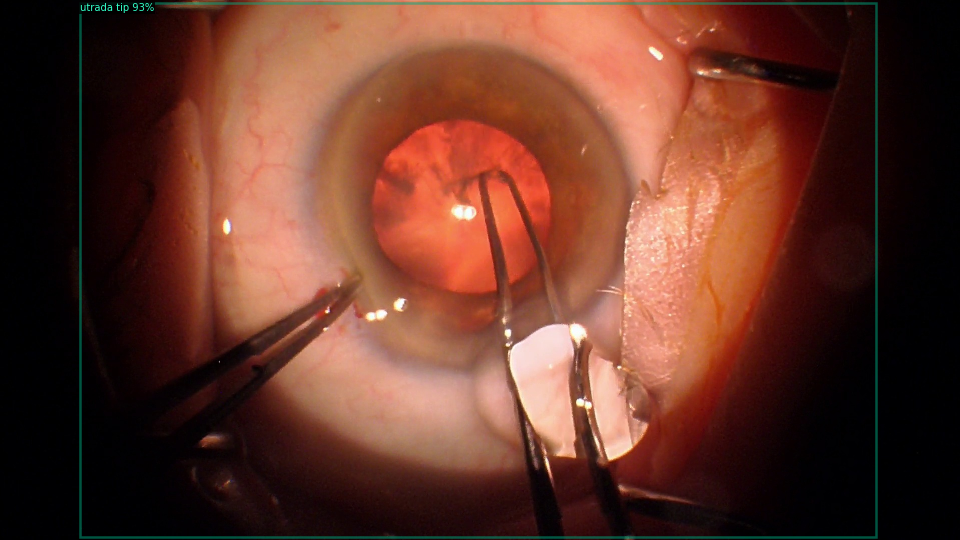

{'instances': Instances(num_instances=0, image_height=478, image_width=712, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_keypoints: tensor([], device='cuda:0', size=(0, 2, 3)), pred_keypoint_heatmaps: tensor([], device='cuda:0', size=(0, 2, 56, 56))])}


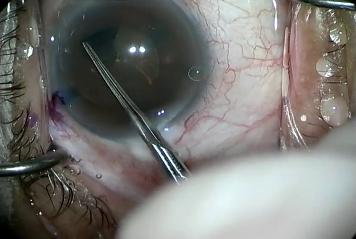

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("my_dataset_train") 
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    print(outputs)
    
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("my_dataset_train"), 
                   scale=0.5
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Evaluate performance using COCO AP metric

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_train", output_dir="./output", kpt_oks_sigmas=([1.0, 1.0]))

val_loader = build_detection_test_loader(cfg, "my_dataset_train")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/12 20:24:02 d2.data.datasets.coco]: Loaded 320 images in COCO format from /content/drive/MyDrive/Rhexis/train_coco_keypoints_annotations2_modified_bbox.json
[04/12 20:24:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/12 20:24:02 d2.data.common]: Serializing 320 elements to byte tensors and concatenating them all ...
[04/12 20:24:02 d2.data.common]: Serialized dataset takes 0.10 MiB
[04/12 20:24:02 d2.evaluation.evaluator]: Start inference on 320 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/12 20:24:06 d2.evaluation.evaluator]: Inference done 11/320. Dataloading: 0.0020 s/iter. Inference: 0.3464 s/iter. Eval: 0.0001 s/iter. Total: 0.3485 s/iter. ETA=0:01:47


/usr/local/lib/python3.7/dist-packages/detectron2/structures/keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


[04/12 20:24:11 d2.evaluation.evaluator]: Inference done 26/320. Dataloading: 0.0024 s/iter. Inference: 0.3463 s/iter. Eval: 0.0002 s/iter. Total: 0.3490 s/iter. ETA=0:01:42
[04/12 20:24:16 d2.evaluation.evaluator]: Inference done 41/320. Dataloading: 0.0025 s/iter. Inference: 0.3466 s/iter. Eval: 0.0002 s/iter. Total: 0.3496 s/iter. ETA=0:01:37
[04/12 20:24:21 d2.evaluation.evaluator]: Inference done 56/320. Dataloading: 0.0024 s/iter. Inference: 0.3474 s/iter. Eval: 0.0002 s/iter. Total: 0.3503 s/iter. ETA=0:01:32
[04/12 20:24:27 d2.evaluation.evaluator]: Inference done 70/320. Dataloading: 0.0024 s/iter. Inference: 0.3492 s/iter. Eval: 0.0002 s/iter. Total: 0.3521 s/iter. ETA=0:01:28
[04/12 20:24:32 d2.evaluation.evaluator]: Inference done 84/320. Dataloading: 0.0024 s/iter. Inference: 0.3515 s/iter. Eval: 0.0003 s/iter. Total: 0.3544 s/iter. ETA=0:01:23
[04/12 20:24:37 d2.evaluation.evaluator]: Inference done 98/320. Dataloading: 0.0024 s/iter. Inference: 0.3535 s/iter. Eval: 0.000